# Exploring in-process query options for Parquet 
This notebook explores using datafusion and DuckDB for querying Parquet data files holding NWM, xref, and usgs actual data.

## Getting initial parquet data for the NWM

This first code block will run for a while and generate the parquet files for the time period specified in the script.

The code block then moves the parquet files to data/nwm/ to keep track of which parquet files are associated with particular output; as there will be multiple sets of parquet files.


In [1]:
# this was actually run from a bash prompt prior to the current placement into the explore folder
# may need to be tweaked to get the path right
!cd ../hydro-evaluation/parquet
!#python3 nwm_to_parquet.py #commented out so it isn't run by accident
! cd ../..
! mkdir -p data/nwm/
!#mv parquet/*.parquet data/nwm/ #prevent run by accident


In [8]:
# adding project dirs to path so code may be referenced from the notebook
import sys
sys.path.insert(0, '../hydro-evaluation/wide_table')
sys.path.insert(0, '../hydro-evaluation')

In [9]:
import utils
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/ctownsend/projects/hydro-evaluation/src/exploration/../hydro-evaluation/wide_table/utils.py'>

In [10]:
file = "../hydro-evaluation/data/RouteLink_CONUS_NWMv2.1.6.csv"
xwalk_data = utils.get_xwalk(file)
xwalk_data.head()

,nwm_feature_id,usgs_site_code,latitude,longitude
0,7086109,05106000,48.987790,-95.66818
1,7040481,05078520,47.795300,-96.27213
2,7053819,05078470,47.746620,-96.20325
3,7111205,05125039,47.763350,-91.73828
4,7110249,05124982,47.835423,-91.65367


In [11]:
from pathlib import Path
import os
xwalk_data2 = utils.get_xwalk() #tests original method without file path
xwalk_data2.head()

,nwm_feature_id,usgs_site_code,latitude,longitude
0,7086109,05106000,48.987790,-95.66818
1,7040481,05078520,47.795300,-96.27213
2,7053819,05078470,47.746620,-96.20325
3,7111205,05125039,47.763350,-91.73828
4,7110249,05124982,47.835423,-91.65367


In [64]:
!pip3 install pyarrow

  Using cached pyarrow-10.0.1-cp39-cp39-macosx_11_0_arm64.whl (23.0 MB)


In [68]:
xwalk_data.to_parquet("../hydro-evaluation/data/xwalk.parquet")

In [ ]:
%env HDF5_DIR=/opt/homebrew/opt/hdf5
!pip3 install hydrotools

In [88]:
# replicating the ingest_usgs code here so the data may be
# saved as parquet data rather than inserted into the timeseriesDB
from hydrotools.nwis_client.iv import IVDataService
from datetime import datetime, timedelta
from insert_usgs import fetch_usgs

start = datetime(2022, 10, 1)
download_period = timedelta(days=1)
number_of_periods = 30

for p in range(number_of_periods):
    print("Processing: ", p)
    start_dt = (start + download_period * p)
    end_dt = (start + download_period * (p + 1))
    start_dt_str = start_dt.strftime("%Y-%m-%d")
    end_dt_str = end_dt.strftime("%Y-%m-%d")

    observations_data = fetch_usgs(
        start_dt=start_dt_str,
        end_dt=end_dt_str
    )
    
    observations_data.set_index("value_time", inplace=True)
    obs = observations_data[
        observations_data.index.hour.isin(range(0, 23)) 
        & (observations_data.index.minute == 0) 
        & (observations_data.index.second == 0)
    ]
    obs.reset_index(level=0, allow_duplicates=True, inplace=True)
    obs.to_parquet("../hydro-evaluation/data/usgs/" + str(p) + ".parquet")


# loading sampe data from TimescaleDB

In [100]:
import pandas as pd
query1_head = pd.read_csv("query1_head.csv")

query1_head

,Unnamed: 0,reference_time,nwm_feature_id,intercept,covariance,corr,r_squared,forecast_count,observed_count,forecast_average,observed_average,forecast_variance,observed_variance,max_forecast_delta,bias
0,0,2022-10-20 12:00:00+00:00,2441678,134.422416,23.674599,0.120202,0.014449,230,230,144.315687,58.553478,276.849847,140.118481,11.793626,-85.762208
1,1,2022-10-20 06:00:00+00:00,2441678,135.384477,23.060206,0.112236,0.012597,230,230,144.977451,58.489130,300.246465,140.599925,12.146764,-86.488321
2,2,2022-10-20 00:00:00+00:00,2441678,135.080402,23.333965,0.109885,0.012075,230,230,144.705681,58.382609,318.598568,141.533321,12.146764,-86.323073
3,3,2022-10-19 18:00:00+00:00,2441678,138.104020,17.110903,0.084001,0.007056,230,230,145.140207,58.333478,292.495062,141.857870,12.499919,-86.806728
4,4,2022-10-19 12:00:00+00:00,2441678,137.181925,17.343053,0.080398,0.006464,230,230,144.346394,58.366087,329.354359,141.286967,12.853057,-85.980307


In [101]:
query2_head = pd.read_csv("query2_head.csv")

query2_head

,Unnamed: 0,reference_time,nwm_feature_id,value_time,intercept,covariance,corr,r_squared,forecast_count,observed_count,forecast_average,observed_average,forecast_variance,observed_variance,max_forecast_delta,bias
0,0,2022-10-01 00:00:00+00:00,17003262,2022-10-01 01:00:00+00:00,NaN,NaN,NaN,NaN,1,1,0.353147,0.23,NaN,NaN,0.123147,-0.123147
1,1,2022-10-01 00:00:00+00:00,17003262,2022-10-01 02:00:00+00:00,NaN,NaN,NaN,NaN,1,1,0.353147,0.23,NaN,NaN,0.123147,-0.123147
2,2,2022-10-01 00:00:00+00:00,17003262,2022-10-01 03:00:00+00:00,NaN,NaN,NaN,NaN,1,1,0.353147,0.31,NaN,NaN,0.043147,-0.043147
3,3,2022-10-01 00:00:00+00:00,17003262,2022-10-01 04:00:00+00:00,NaN,NaN,NaN,NaN,1,1,0.353147,0.31,NaN,NaN,0.043147,-0.043147
4,4,2022-10-01 00:00:00+00:00,17003262,2022-10-01 05:00:00+00:00,NaN,NaN,NaN,NaN,1,1,0.353147,0.31,NaN,NaN,0.043147,-0.043147


In [102]:
query3_head = pd.read_csv("query3_head.csv")

query3_head

,Unnamed: 0,reference_time,value_time,nwm_feature_id,forecast_value,configuration,measurement_unit,variable_name,geom,observed_value,usgs_site_code,lead_time
0,0,2022-10-01 00:00:00+00:00,2022-10-01 01:00:00+00:00,17003262,0.353147,medium_range_mem1,ft3/s,streamflow,0101000020E6100000E76F422102105BC02D3E05C0785E...,0.23,9367500,0 days 01:00:00
1,1,2022-10-01 00:00:00+00:00,2022-10-01 02:00:00+00:00,17003262,0.353147,medium_range_mem1,ft3/s,streamflow,0101000020E6100000E76F422102105BC02D3E05C0785E...,0.23,9367500,0 days 02:00:00
2,2,2022-10-01 00:00:00+00:00,2022-10-01 03:00:00+00:00,17003262,0.353147,medium_range_mem1,ft3/s,streamflow,0101000020E6100000E76F422102105BC02D3E05C0785E...,0.31,9367500,0 days 03:00:00
3,3,2022-10-01 00:00:00+00:00,2022-10-01 04:00:00+00:00,17003262,0.353147,medium_range_mem1,ft3/s,streamflow,0101000020E6100000E76F422102105BC02D3E05C0785E...,0.31,9367500,0 days 04:00:00
4,4,2022-10-01 00:00:00+00:00,2022-10-01 05:00:00+00:00,17003262,0.353147,medium_range_mem1,ft3/s,streamflow,0101000020E6100000E76F422102105BC02D3E05C0785E...,0.31,9367500,0 days 05:00:00


# Exploring datafusion
A SQL engine on top of various file formats including Parquet; does not yet have enough stats functions to be immediately useful via SQL; 
## results
- consumed all available memory for query1 and then failed; ran for a very long time
- tried to modify query many different ways with same result
- for some reason, query planner did not like simple in statement; couldn't find any documentation for why this would be a problem
- do not recommend as it is too brittle and not as memory efficient as advertised for our use case

In [1]:
!pip3 install datafusion

In [12]:
import datafusion as df
ctx = df.SessionContext()

ctx.register_parquet('nd', '../hydro-evaluation/data/nwm/*.parquet')
ctx.register_parquet('nux', '../hydro-evaluation/data/xwalk.parquet')
ctx.register_parquet('ud', '../hydro-evaluation/data/usgs/*.parquet')


In [15]:
from datafusion import col

query = """
    SELECT nd.reference_time,
        nd.value_time,
        nd.nwm_feature_id,   
        nd.value as forecast_value, 
        nd.configuration,  
        nd.measurement_unit,     
        nd.variable_name,
        nux.latitude,
        nux.longitude,
        ud.value as observed_value,
        ud.usgs_site_code
    FROM nd 
    JOIN nux 
        on nux.nwm_feature_id = nd.nwm_feature_id 
    JOIN ud 
        on nux.usgs_site_code  = ud.usgs_site_code 
        and nd.value_time = ud.value_time 
        and nd.measurement_unit = ud.measurement_unit
        and nd.variable_name = ud.variable_name
                    where nd.nwm_feature_id in (select 6731199,2441678,14586327,8573705,2567762,41002752,8268521,41026212,4709060,20957306)


"""
query = """
    select nd.reference_time,
        nd.value_time,
        nd.nwm_feature_id,   
        nd.value as forecast_value, 
        nd.configuration,  
        nd.measurement_unit,     
        nd.variable_name,
        nux.latitude,
        nux.longitude
    from nd
    join nux 
        on nux.nwm_feature_id = nd.nwm_feature_id
    JOIN ud 
        on nux.usgs_site_code  = ud.usgs_site_code 
        and nd.value_time = ud.value_time 
        and nd.measurement_unit = ud.measurement_unit
        and nd.variable_name = ud.variable_name
    where nd.nwm_feature_id in (select 6731199,2441678,14586327,8573705,2567762,41002752,8268521,41026212,4709060,20957306)
"""
df = ctx.sql(query)
df.show()
#df.filter(col("nwm_feature_id") == 6731199)

thread 'tokio-runtime-worker' panicked at 'MutableArrayData::new is infallible: DictionaryKeyOverflowError', /Users/ctownsend/.cargo/registry/src/github.com-1ecc6299db9ec823/arrow-data-26.0.0/src/transform/mod.rs:565:31
thread 'tokio-runtime-worker' panicked at 'MutableArrayData::new is infallible: DictionaryKeyOverflowError', /Users/ctownsend/.cargo/registry/src/github.com-1ecc6299db9ec823/arrow-data-26.0.0/src/transform/mod.rs:565:31
thread 'tokio-runtime-worker' panicked at 'MutableArrayData::new is infallible: DictionaryKeyOverflowError', /Users/ctownsend/.cargo/registry/src/github.com-1ecc6299db9ec823/arrow-data-26.0.0/src/transform/mod.rs:565:31
thread 'tokio-runtime-worker' panicked at 'MutableArrayData::new is infallible: DictionaryKeyOverflowError', /Users/ctownsend/.cargo/registry/src/github.com-1ecc6299db9ec823/arrow-data-26.0.0/src/transform/mod.rs:565:31
thread 'tokio-runtime-worker' panicked at 'MutableArrayData::new is infallible: DictionaryKeyOverflowError', /Users/ctow

++
++


# exploring DuckDB

## results
- very efficent use of memory; never much more than the memory allocated for the notebook service
- very fast query execution and fetch times
- query planner had no problems with any of the existing or modified SQL statements
- additional performance tuning possibilities down the road, things similar to materialized views
- integrates really well with Python and other languages

In [24]:
!pip3 install duckdb

In [14]:
import duckdb as ddb
con = ddb.connect(database='explore.duckdb')

In [15]:
query = """
    with joined as (
        SELECT 
        nd.reference_time,
        nd.value_time,
        nd.nwm_feature_id,   
        nd.value as forecast_value, 
        nd.configuration,  
        nd.measurement_unit,     
        nd.variable_name,
        --nux.geom as geom, 
        ud.value as observed_value,
        ud.usgs_site_code,
        nd.value_time - nd.reference_time as lead_time
        FROM '../hydro-evaluation/data/nwm/*.parquet'  nd 
        JOIN '../hydro-evaluation/data/xwalk.parquet'  nux 
        on nux.nwm_feature_id = nd.nwm_feature_id 
        JOIN '../hydro-evaluation/data/usgs/*.parquet'  ud 
        on nux.usgs_site_code  = ud.usgs_site_code 
        and nd.value_time = ud.value_time 
        and nd.measurement_unit = ud.measurement_unit
        and nd.variable_name = ud.variable_name
        where nd.nwm_feature_id in (6731199,2441678,14586327,8573705,2567762,41002752,8268521,41026212,4709060,20957306)
    )
    select 
    reference_time, 
    nwm_feature_id,
    regr_intercept(forecast_value, observed_value) as intercept,
    covar_pop(forecast_value, observed_value) as covariance,
    corr(forecast_value, observed_value) as corr,
    regr_r2(forecast_value, observed_value) as r_squared,
    count(forecast_value) as forecast_count,
    count(observed_value) as observed_count,
    avg(forecast_value) as forecast_average,
    avg(observed_value) as observed_average,
    var_pop(forecast_value) as forecast_variance,
    var_pop(observed_value) as observed_variance,
    sum(observed_value - forecast_value)/count(*) as bias,
    max(forecast_value) - max(observed_value) as max_forecast_delta
    from joined 
    group by reference_time, nwm_feature_id
    order by nwm_feature_id, max_forecast_delta;
"""

query1_df = con.execute(query).df()
query1_df.head()

,reference_time,nwm_feature_id,intercept,covariance,corr,r_squared,forecast_count,observed_count,forecast_average,observed_average,forecast_variance,observed_variance,bias,max_forecast_delta
0,2022-10-20 12:00:00,2441678,134.422416,23.571664,0.120202,0.014449,230,230,144.315687,58.553478,275.646152,139.509268,-85.762208,11.793626
1,2022-10-20 06:00:00,2441678,135.384476,22.959946,0.112236,0.012597,230,230,144.977451,58.489130,298.941046,139.988618,-86.488320,12.146764
2,2022-10-20 00:00:00,2441678,135.080401,23.232515,0.109885,0.012075,230,230,144.705681,58.382609,317.213357,140.917956,-86.323073,12.146764
3,2022-10-19 18:00:00,2441678,138.104020,17.036507,0.084001,0.007056,230,230,145.140207,58.333478,291.223345,141.241094,-86.806728,12.499919
4,2022-10-19 12:00:00,2441678,137.181926,17.267646,0.080398,0.006464,230,230,144.346394,58.366087,327.922383,140.672673,-85.980307,12.853057


<AxesSubplot: xlabel='reference_time'>

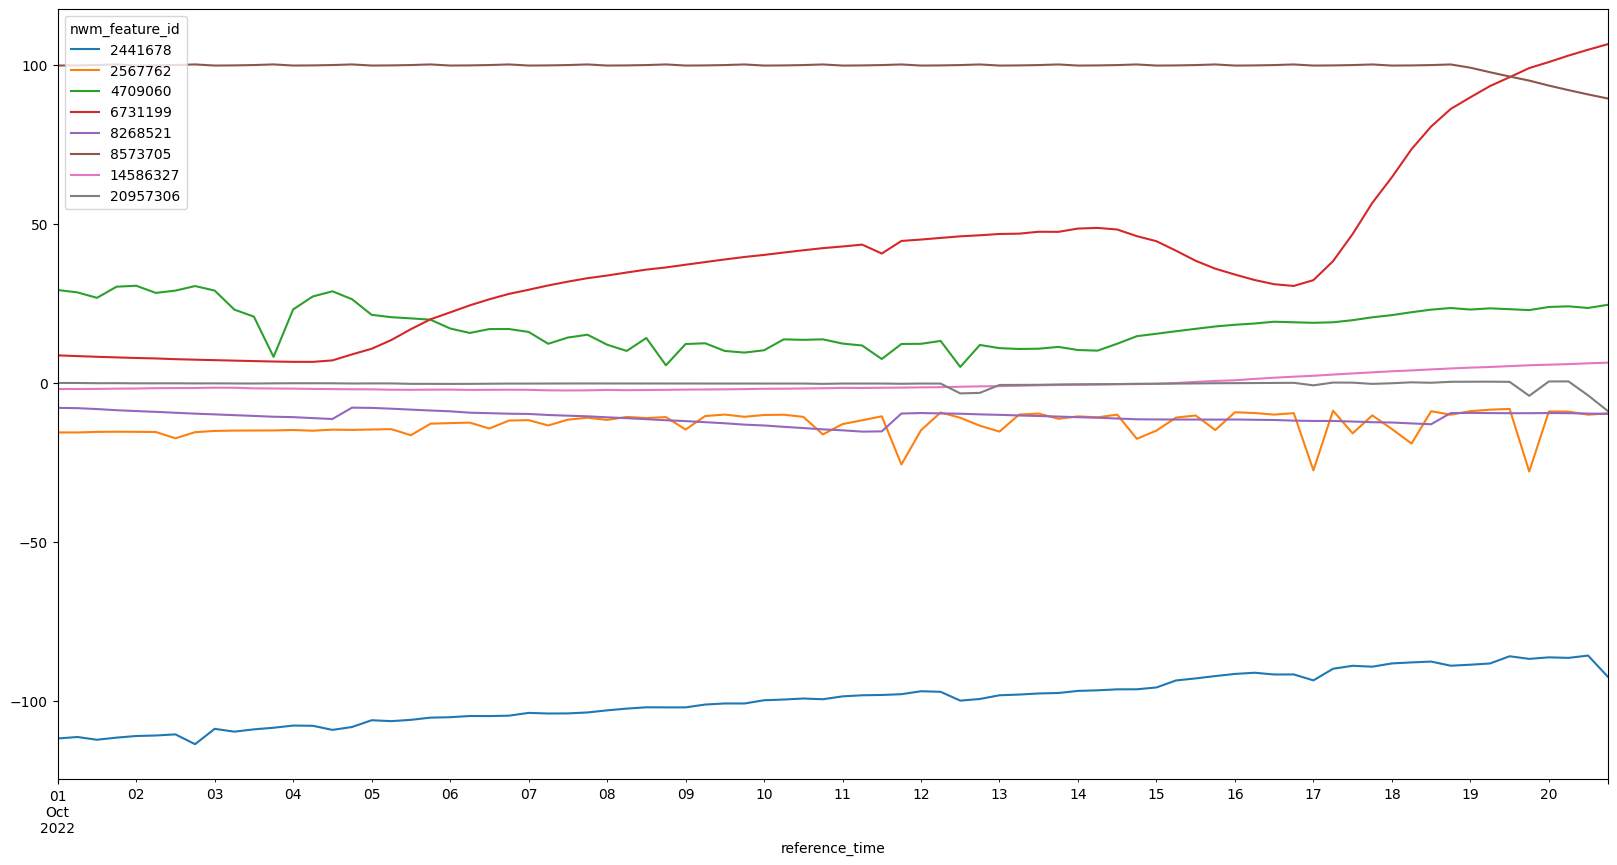

In [3]:
bias = query1_df.pivot(index="reference_time", columns="nwm_feature_id", values="bias")
bias.plot(figsize=(20,10))

In [16]:
nwm_feature_id = 17003262
configuration = 'medium_range_mem1'

query = f"""
    SELECT 
    nd.reference_time,
    nd.nwm_feature_id,   
    nd.value_time,
    regr_intercept(nd.value, ud.value) as intercept,
    covar_pop(nd.value, ud.value) as covariance,
    corr(nd.value, ud.value) as corr,
    regr_r2(nd.value, ud.value) as r_squared,
    count(nd.value) as forecast_count,
    count(ud.value) as observed_count,
    avg(nd.value) as forecast_average,
    avg(ud.value) as observed_average,
    var_pop(nd.value) as forecast_variance,
    var_pop(ud.value) as observed_variance,
    max(nd.value) - max(ud.value) as max_forecast_delta,
    sum(ud.value - nd.value)/count(*) as bias
    FROM '../hydro-evaluation/data/nwm/*.parquet'  nd 
    JOIN '../hydro-evaluation/data/xwalk.parquet'  nux 
        on nux.nwm_feature_id = nd.nwm_feature_id 
    JOIN '../hydro-evaluation/data/usgs/*.parquet'  ud 
        on nux.usgs_site_code  = ud.usgs_site_code 
        and nd.value_time = ud.value_time 
        and nd.measurement_unit = ud.measurement_unit
        and nd.variable_name = ud.variable_name
    where nd.nwm_feature_id = {nwm_feature_id}
    and configuration = '{configuration}'
    group by nd.reference_time,
    nd.nwm_feature_id,   
    nd.value_time
"""
query2_df = con.execute(query).df()
query2_df.head()

,reference_time,nwm_feature_id,value_time,intercept,covariance,corr,r_squared,forecast_count,observed_count,forecast_average,observed_average,forecast_variance,observed_variance,max_forecast_delta,bias
0,2022-10-08,17003262,2022-10-08 09:00:00,NaN,0.0,NaN,NaN,1,1,3.531466,12.50,0.0,0.0,-8.968534,8.968534
1,2022-10-08,17003262,2022-10-08 21:00:00,NaN,0.0,NaN,NaN,1,1,2.118880,11.50,0.0,0.0,-9.381120,9.381120
2,2022-10-08,17003262,2022-10-09 14:00:00,NaN,0.0,NaN,NaN,1,1,1.059440,8.73,0.0,0.0,-7.670560,7.670560
3,2022-10-08,17003262,2022-10-09 18:00:00,NaN,0.0,NaN,NaN,1,1,1.059440,8.16,0.0,0.0,-7.100560,7.100560
4,2022-10-08,17003262,2022-10-10 00:00:00,NaN,0.0,NaN,NaN,1,1,1.059440,7.11,0.0,0.0,-6.050560,6.050560


In [17]:
query = """
SELECT 
    nd.reference_time,
    nd.value_time,
    nd.nwm_feature_id,   
    nd.value as forecast_value, 
    nd.configuration,  
    nd.measurement_unit,     
    nd.variable_name,
    nux.latitude,
    nux.longitude,
    ud.value as observed_value,
    ud.usgs_site_code,
    nd.value_time - nd.reference_time as lead_time
FROM '../hydro-evaluation/data/nwm/*.parquet'  nd 
JOIN '../hydro-evaluation/data/xwalk.parquet'  nux 
    on nux.nwm_feature_id = nd.nwm_feature_id 
JOIN '../hydro-evaluation/data/usgs/*.parquet'  ud 
    on nux.usgs_site_code  = ud.usgs_site_code 
    and nd.value_time = ud.value_time 
    and nd.measurement_unit = ud.measurement_unit
    and nd.variable_name = ud.variable_name
where configuration = 'medium_range_mem1'
and nd.nwm_feature_id = 17003262
order by reference_time, nd.nwm_feature_id;
"""
query3_df = con.execute(query).df()
query3_df.head()

,reference_time,value_time,nwm_feature_id,forecast_value,configuration,measurement_unit,variable_name,latitude,longitude,observed_value,usgs_site_code,lead_time
0,2022-10-01,2022-10-01 01:00:00,17003262,0.353147,medium_range_mem1,ft3/s,streamflow,36.73806,-108.25013,0.23,09367500,0 days 01:00:00
1,2022-10-01,2022-10-01 02:00:00,17003262,0.353147,medium_range_mem1,ft3/s,streamflow,36.73806,-108.25013,0.23,09367500,0 days 02:00:00
2,2022-10-01,2022-10-01 03:00:00,17003262,0.353147,medium_range_mem1,ft3/s,streamflow,36.73806,-108.25013,0.31,09367500,0 days 03:00:00
3,2022-10-01,2022-10-01 04:00:00,17003262,0.353147,medium_range_mem1,ft3/s,streamflow,36.73806,-108.25013,0.31,09367500,0 days 04:00:00
4,2022-10-01,2022-10-01 05:00:00,17003262,0.353147,medium_range_mem1,ft3/s,streamflow,36.73806,-108.25013,0.31,09367500,0 days 05:00:00


<AxesSubplot: xlabel='value_time'>

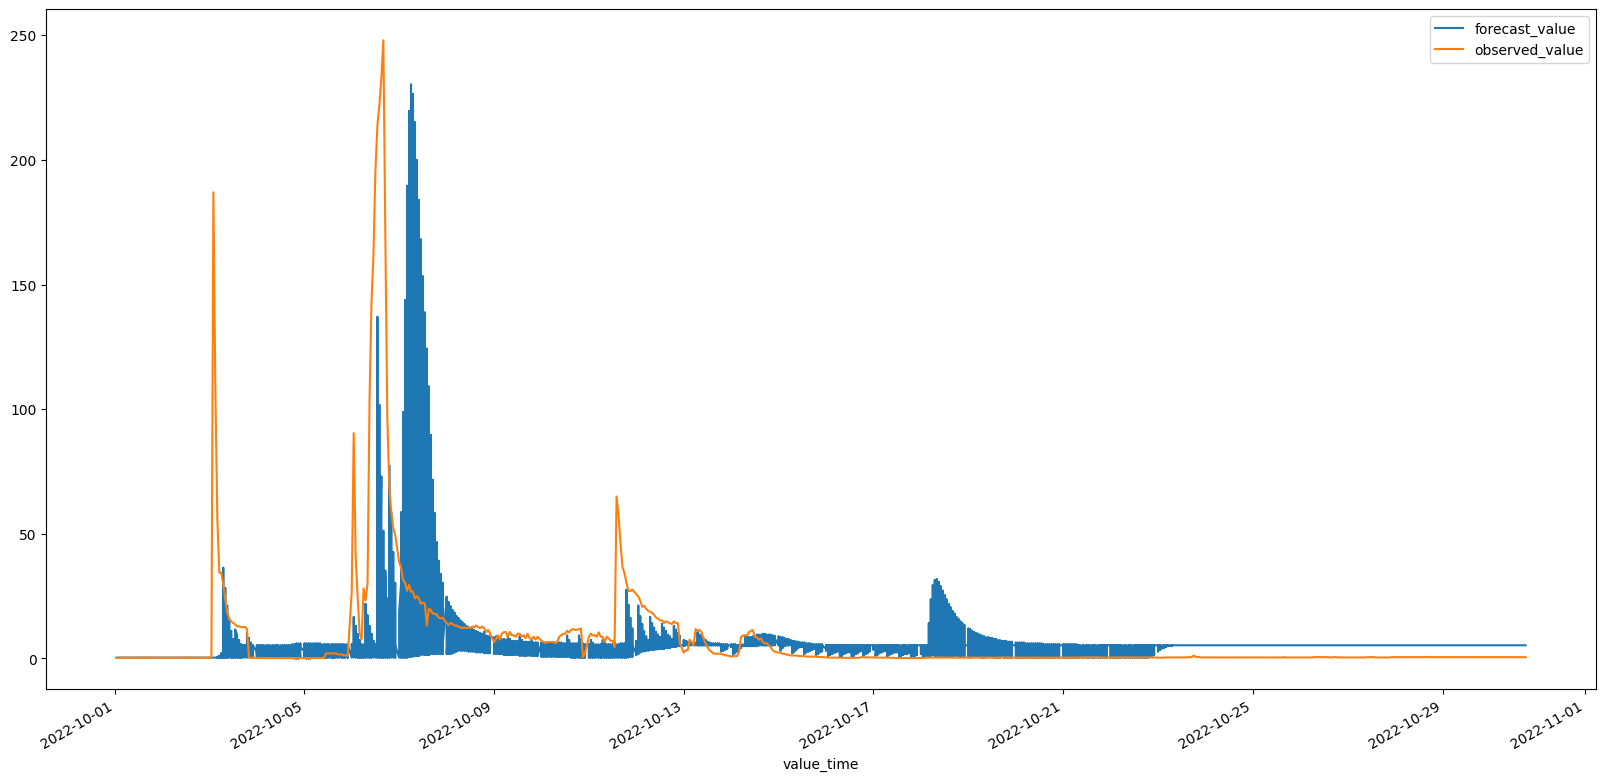

In [22]:
import matplotlib.pyplot as plt

ax = plt.gca()
query3_df.plot(x= 'value_time', y="forecast_value", ax = ax, figsize=(20,10))
query3_df.plot(x= 'value_time', y="observed_value", ax = ax, figsize=(20,10))


# Next steps?
- Initial example dashboard with larger data set for DuckDB?
- Dash appears to be a better choice:
    - subjectively dashboard examples look better out of the box on demo sites
    - stack would be easier to customize if needed: Python, Flask, Plotly, React
    - supports multiple languages: Python, R, Julia
- How best to handle geospatial data types?
    - Geospatial data types are not yet part of DuckDB, looks like it is being discussed in their issues/tickets
    - Explore GeoParquet with GeoPandas(extension of Pandas for geospatial types and operations)
    - SpatiaLite as option to investigate handling of geospatial data with another query to DuckDB parquet data
    - GDAL/Parquet handling
    - Potential for a linked server between SpatiaLite and DuckDB with a view in DuckDB to all the Parquet data exposed to SpatiaLite for handling geospatial conversions
    
    